In [1]:
import numpy as np
import tensorflow as tf
from utils import load_data, train_test_split
from matplotlib import pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.metrics import f1_score

%matplotlib inline

/Users/admin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Import MNIST data

In [2]:
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


# Converting the downloaded images from 1x784 format to 28x28

In [3]:
x_train = np.array([np.reshape(x, (28,28)) for x in mnist.train.images])
x_test = np.array([np.reshape(x, (28,28)) for x in mnist.test.images])

print("X-Train", x_train.shape, "," " X-Test", x_test.shape)

X-Train (55000, 28, 28) , X-Test (10000, 28, 28)


In [4]:
# Convert labels into one-hot encoded vectors
y_train = mnist.train.labels
y_test = mnist.test.labels

print("Y-Train", y_train.shape, "," " Y-Test", y_test.shape)

Y-Train (55000,) , Y-Test (10000,)


In [5]:
# Set model parameters
batch_size = 100
learning_rate = 0.01
evaluation_size = 500
image_width = x_train[0].shape[0]
image_height = x_train[0].shape[1]
target_size = max(y_train) + 1
num_channels = 1           
generations = 500
eval_every = 5
conv1_features = 25
conv2_features = 50
max_pool_size1 = 2  
max_pool_size2 = 2 
fully_connected = 100

# Input Layer

In [26]:
x_input_shape = (batch_size, image_width, image_height, num_channels)
x_input = tf.placeholder(tf.float32, shape=x_input_shape, name="X-input")
y_target = tf.placeholder(tf.int32, shape=batch_size, name="Y-output")

In [27]:
eval_input_shape = (evaluation_size, image_width, image_height, num_channels)
eval_input = tf.placeholder(tf.float32, shape=eval_input_shape, name="eval-input")
eval_target = tf.placeholder(tf.int32, shape=(evaluation_size), name="eval-output")

# Convolutional Layer 

In [7]:
conv1_weight = tf.Variable(tf.truncated_normal([4, 4, num_channels, conv1_features], stddev=0.1, dtype=tf.float32))
conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))

In [8]:
conv2_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_features, conv2_features], stddev=0.1, dtype=tf.float32))
conv2_bias = tf.Variable(tf.zeros([conv2_features], dtype=tf.float32))

# Connected Variables

In [9]:
resulting_width = image_width // (max_pool_size1 * max_pool_size2)
resulting_height = image_height // (max_pool_size1 * max_pool_size2)
fully_conn_input = resulting_width * resulting_height * conv2_features
fully_conn_weight1 = tf.Variable(tf.truncated_normal([fully_conn_input, fully_connected], stddev=0.1, dtype=tf.float32))
fully_conn_bias1 = tf.Variable(tf.truncated_normal([fully_connected], stddev=0.1, dtype=tf.float32))
fully_conn_weight2 = tf.Variable(tf.truncated_normal([fully_connected, target_size], stddev=0.1, dtype=tf.float32))
fully_conn_bias2 = tf.Variable(tf.truncated_normal([target_size], stddev=0.1, dtype=tf.float32))

# Initializing the Model Operations

In [10]:
def my_conv_net(input_data):
    
    # First Conv-ReLU-MaxPool Layer
    conv1 = tf.nn.conv2d(input_data, conv1_weight, strides=[1, 1, 1, 1], padding='SAME')
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
    max_pool1 = tf.nn.max_pool(relu1, ksize=[1, max_pool_size1, max_pool_size1, 1], strides=[1, max_pool_size1, max_pool_size1, 1], padding='SAME')

    # Second Conv-ReLU-MaxPool Layer
    conv2 = tf.nn.conv2d(max_pool1, conv2_weight, strides=[1, 1, 1, 1], padding='SAME')
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_bias))
    max_pool2 = tf.nn.max_pool(relu2, ksize=[1, max_pool_size2, max_pool_size2, 1], strides=[1, max_pool_size2, max_pool_size2, 1], padding='SAME')

    # Transform the Output into a 1xN layer for next fully connected layer
    conv_shape = max_pool2.get_shape().as_list()
    fn_shape = conv_shape[1] * conv_shape[2] * conv_shape[3]
    flat_output = tf.reshape(max_pool2, [conv_shape[0], fn_shape])

    # First Fully Connected Layer
    fully_connected = tf.nn.relu(tf.add(tf.matmul(flat_output, fully_conn_weight1), fully_conn_bias1))

    # Second Fully Connected Layer
    model_output = tf.add(tf.matmul(fully_connected, fully_conn_weight2), fully_conn_bias2)
    
    return(model_output)

In [11]:
logits = my_conv_net(x_input)
print(logits)

Tensor("Add_1:0", shape=(100, 10), dtype=float32)


In [12]:
test_logit = my_conv_net(eval_input)
print(test_logit)

Tensor("Add_3:0", shape=(500, 10), dtype=float32)


# Declaration of Loss Function

In [13]:
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y_target))

# Creating a Prediction Function for train and test

In [14]:
prediction = tf.nn.softmax(logits)
test_prediction = tf.nn.softmax(test_logit)

# Creating Accuracy Function

In [28]:
def get_accuracy(logits, targets):
    batch_predictions = np.argmax(logits, axis=1)
    num_correct = np.sum(np.equal(batch_predictions, targets))
    accuracy = (100 * num_correct / batch_predictions.shape[0])
    return accuracy

# Create an Optimizer

In [16]:
train_step = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(loss)

# Training Our Model and printing Analysis 

In [22]:
with tf.Session() as sess:
    # Initializing Variables
    init = tf.global_variables_initializer()
    sess.run(init)
    
    # Starting training loop
    train_loss = []
    train_acc = []
    test_acc = []
    for i in range(generations):
        rand_index = np.random.choice(len(x_train), size=batch_size)
        rand_x = x_train[rand_index]
        rand_x = np.expand_dims(rand_x, 3)
        rand_y = y_train[rand_index]
        train_dict = {x_input: rand_x, y_target: rand_y}

        sess.run(train_step, feed_dict=train_dict)
        temp_train_loss, temp_train_preds = sess.run([loss, prediction], feed_dict=train_dict)
        temp_train_acc = get_accuracy(temp_train_preds, rand_y)

        if (i+1) % eval_every == 0:
            eval_index = np.random.choice(len(x_test), size=evaluation_size)
            eval_x = x_test[eval_index]
            eval_x = np.expand_dims(eval_x, 3)
            eval_y = y_test[eval_index]
            test_dict = {eval_input: eval_x, eval_target: eval_y}
            test_preds = sess.run(test_prediction, feed_dict=test_dict)
            temp_test_acc = get_accuracy(test_preds, eval_y)

            # Recording and printing results
            train_loss.append(temp_train_loss)
            train_acc.append(temp_train_acc)
            test_acc.append(temp_test_acc)
            acc_and_loss = [(i+1), temp_train_loss, temp_train_acc, temp_test_acc]
            acc_and_loss = [np.round(x,2) for x in acc_and_loss]
            print('Generation: {}. Training Loss: {:.2f}. Training Accuracy: {:.2f}. Test Accuracy: {:.2f}'.format(*acc_and_loss))  
            
           
    print("Optimization has finished!")

Generation: 5. Training Loss: 2.19. Training Accuracy: 20.00. Test Accuracy: 21.20
Generation: 10. Training Loss: 2.03. Training Accuracy: 34.00. Test Accuracy: 39.40
Generation: 15. Training Loss: 1.79. Training Accuracy: 51.00. Test Accuracy: 59.20
Generation: 20. Training Loss: 1.27. Training Accuracy: 64.00. Test Accuracy: 61.00
Generation: 25. Training Loss: 0.87. Training Accuracy: 77.00. Test Accuracy: 74.80
Generation: 30. Training Loss: 0.89. Training Accuracy: 70.00. Test Accuracy: 72.20
Generation: 35. Training Loss: 0.44. Training Accuracy: 79.00. Test Accuracy: 80.80
Generation: 40. Training Loss: 0.39. Training Accuracy: 89.00. Test Accuracy: 78.20
Generation: 45. Training Loss: 0.36. Training Accuracy: 87.00. Test Accuracy: 82.00
Generation: 50. Training Loss: 0.44. Training Accuracy: 85.00. Test Accuracy: 88.40
Generation: 55. Training Loss: 0.28. Training Accuracy: 91.00. Test Accuracy: 87.60
Generation: 60. Training Loss: 0.31. Training Accuracy: 91.00. Test Accuracy:

Generation: 490. Training Loss: 0.15. Training Accuracy: 95.00. Test Accuracy: 96.60
Generation: 495. Training Loss: 0.05. Training Accuracy: 100.00. Test Accuracy: 95.00
Generation: 500. Training Loss: 0.07. Training Accuracy: 97.00. Test Accuracy: 96.60
Optimization has finished!


# Plotting 6 last batch results:

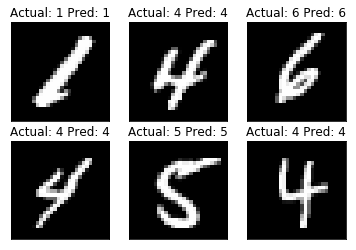

In [23]:
actuals = rand_y[0:6]
predictions = np.argmax(temp_train_preds,axis=1)[0:6]
images = np.squeeze(rand_x[0:6])

Nrows = 2
Ncols = 3
for i in range(6):
    plt.subplot(Nrows, Ncols, i+1)
    plt.imshow(np.reshape(images[i], [28,28]), cmap='Greys_r')
    plt.title('Actual: ' + str(actuals[i]) + ' Pred: '+ str(predictions[i]), fontsize=12)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    
plt.show()

# Plot Loss over Time

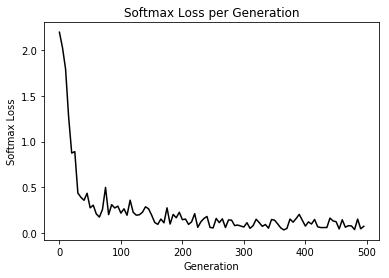

In [24]:
eval_indices = range(0, generations, eval_every)
plt.plot(eval_indices, train_loss, 'k-')
plt.title('Softmax Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Softmax Loss')
plt.show()

# Plot Train and Test Accuracy over the Generated Samples

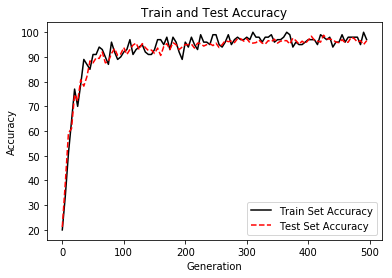

In [25]:
plt.plot(eval_indices, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(eval_indices, test_acc, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()